# Import necessary libraries

In [1]:
import cv2
import math
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from functools import partial
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input as EFNetPreProcessInput

import matplotlib.pyplot as plt
%matplotlib inline

time_now = lambda hours=0: dt.now() + relativedelta(hours=hours) # Set local time

# Record running time of notebook
print(f"Notebook is running at: {time_now()}")
print(f"Current working path: {Path.cwd()}")
print(f"TensorFlow version: {tf.__version__}")

# Dataset in C slot
DATASET_DIR = 'C:\\Users\\User\\Desktop\\Data_Science_Notebook\\projects\\project__cat_dog_classfication_system\\datasets'
DATA_PATH = Path(DATASET_DIR).joinpath('Cats_and_Dogs_Breeds_Classification_Oxford_Dataset\\images\\images')
ANNOTATION_PATH = Path(DATASET_DIR).joinpath('Cats_and_Dogs_Breeds_Classification_Oxford_Dataset\\annotations\\annotations\\list.txt')
print(f"\nDataset Path: \n{DATA_PATH}")
print(f"\nAnnotation List Path: \n{ANNOTATION_PATH}")

# def set_checkpoint(save_path='model_checkpoints/checkpoints_weights.h5'):
#     """
#     Set checkpoint path and callbacks

#     Args:
#       save_path: Path the checkpoint saved to.
#     Return
#       checkpoint callback (str)
#     """
#     # Create ModelCheckpoint callback -> only save weights
#     checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
#                                                              monitor='val_accuracy',
#                                                              mode='max',
#                                                              save_best_only=True, # only save the best weights
#                                                              verbose=1)
    
#     return checkpoint_callback

Notebook is running at: 2024-11-04 00:50:47.264875
Current working path: c:\Users\User\Desktop\cat_dog_project\model_training
TensorFlow version: 2.10.0

Dataset Path: 
C:\Users\User\Desktop\Data_Science_Notebook\projects\project__cat_dog_classfication_system\datasets\Cats_and_Dogs_Breeds_Classification_Oxford_Dataset\images\images

Annotation List Path: 
C:\Users\User\Desktop\Data_Science_Notebook\projects\project__cat_dog_classfication_system\datasets\Cats_and_Dogs_Breeds_Classification_Oxford_Dataset\annotations\annotations\list.txt


# Data preprocessing class

In [2]:
def breed_count(df, title, col_name='CLASSNAME'):
    breed_count  = df[col_name].value_counts()

    plt.figure(figsize=(20,5))
    sns.barplot(x=breed_count.index, y=breed_count.values, alpha=0.8)
    plt.title('Value count of number of ' + title)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Breed Names', fontsize=10)
    plt.xticks(rotation=90)
    plt.show()

In [3]:
class DataTransformer:
    def __init__(self, data_path:str):
        self.data_path = data_path
        
    def read_data(self) -> pd.DataFrame:
        """Read data via pandas module."""
        return pd.read_csv(self.data_path).loc[5:,]

    def preprocess(self) -> pd.DataFrame:
        """
        Preprocess data via following steps:
        1. Read data from a txt file of data_path, return a DataFrame.
        2. Process the columns via splitting operation.
        3. Drop unnecessary columns.
        4. Rename the columns to specific column names.
        5. Convert the object type to int type for further processing.
        6. Add suffix to the image columns with 'jpg' extension.
        7. Extract the classname/breed of the animal, create a new column for labels.

        Returns: DataFrame of preprocessed data.
        """
        df = self.read_data()
        df[['CLASS-ID','SPECIES','BREED','ID']] = df['#Image CLASS-ID SPECIES BREED ID'].str.split(expand=True) 
        df = df.drop('#Image CLASS-ID SPECIES BREED ID', axis=1)
        df = df.rename(columns={'CLASS-ID': 'IMAGE', 'SPECIES': 'CLASS_ID', 'BREED': 'SPECIES', 'ID': 'BREED_ID'})
        df[["CLASS_ID","SPECIES","BREED_ID"]] = df[["CLASS_ID","SPECIES","BREED_ID"]].astype(int)
        df['IMAGE'] = df['IMAGE'].apply(lambda x: str(x) + '.jpg')
        df = df.reset_index()
        df['CLASSNAME'] = df['IMAGE'].apply(lambda x: ' '.join(str(x).split('_')[:-1]))
        df = df.drop('index', axis=1)
        
        return df

In [4]:
data_transformer = DataTransformer(ANNOTATION_PATH)
data_df = data_transformer.preprocess()
data_df

,IMAGE,CLASS_ID,SPECIES,BREED_ID,CLASSNAME
0,Abyssinian_100.jpg,1,1,1,Abyssinian
1,Abyssinian_101.jpg,1,1,1,Abyssinian
2,Abyssinian_102.jpg,1,1,1,Abyssinian
3,Abyssinian_103.jpg,1,1,1,Abyssinian
4,Abyssinian_104.jpg,1,1,1,Abyssinian
...,...,...,...,...,...
7344,yorkshire_terrier_96.jpg,37,2,25,yorkshire terrier
7345,yorkshire_terrier_97.jpg,37,2,25,yorkshire terrier
7346,yorkshire_terrier_98.jpg,37,2,25,yorkshire terrier
7347,yorkshire_terrier_99.jpg,37,2,25,yorkshire terrier


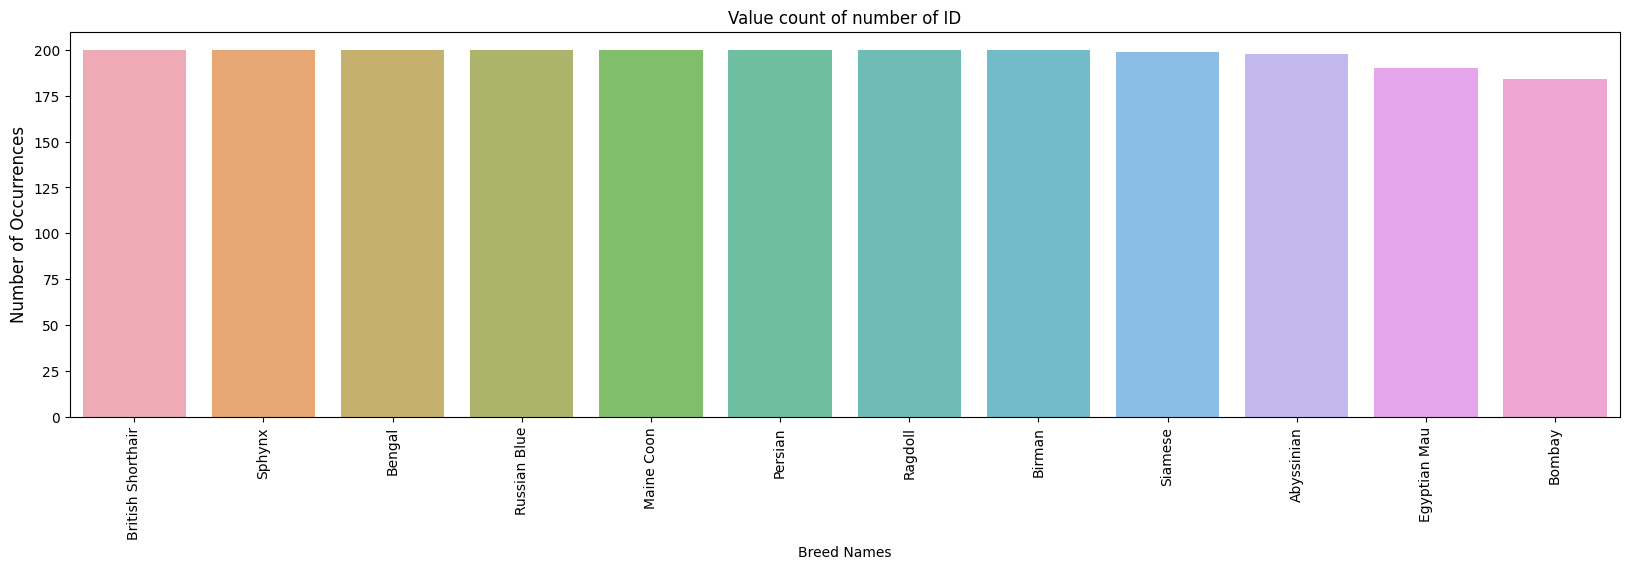

In [5]:
breed_count(data_df[data_df.SPECIES == 1], 'ID', 'CLASSNAME')

# Data augmentation class

In [6]:
class DataAugmentation:
    def __init__(self, 
                 dataframe:pd.DataFrame, 
                 img_data_path:str, 
                 img_size:int=224, 
                 batch_size:int=32, 
                 preprocess_function=EFNetPreProcessInput):
        self.dataframe = dataframe
        self.DATA_PATH = img_data_path
        self.IMG_SIZE = img_size
        self.BATCH_SIZE = batch_size
        self.preprocess_function = preprocess_function
        self.IMG_SHAPE = (self.IMG_SIZE, self.IMG_SIZE)
        self.train_datagen, self.valid_datagen = self.data_generator()
        
    def data_generator(self):
        """Generate data via ImageDataGenerator object."""
        train_datagen = ImageDataGenerator(preprocessing_function=self.preprocess_function,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True,
                                           vertical_flip=True,
                                           validation_split=0.2,
                                           rotation_range=90,
                                           width_shift_range=0.2, 
                                           height_shift_range=0.2)
        
        valid_datagen = ImageDataGenerator(preprocessing_function=self.preprocess_function, 
                                           validation_split=0.2)

        return (train_datagen, valid_datagen)

    def create_flow(self):
        """Create flow data of data generator."""
        self.train_gen_flow = self.train_datagen.flow_from_dataframe(dataframe=self.dataframe,
                                                                     directory=self.DATA_PATH,
                                                                     x_col='IMAGE',
                                                                     y_col='CLASSNAME',
                                                                     target_size=self.IMG_SHAPE,
                                                                     batch_size=self.BATCH_SIZE,
                                                                     class_mode="categorical",
                                                                     subset='training',
                                                                     shuffle=True)
    
        self.valid_gen_flow = self.valid_datagen.flow_from_dataframe(dataframe=self.dataframe,
                                                                     directory=self.DATA_PATH,
                                                                     x_col='IMAGE',
                                                                     y_col='CLASSNAME',
                                                                     target_size=self.IMG_SHAPE,
                                                                     batch_size=self.BATCH_SIZE,
                                                                     class_mode="categorical",
                                                                     subset='validation', 
                                                                     shuffle=False)
        return (self.train_gen_flow, self.valid_gen_flow)

In [7]:
IMG_SIZE = 224
BATCH_SIZE = 32

# Separate cats and dogs
df_cat = data_df[data_df['SPECIES']==1] # cat : 1
df_dog = data_df[data_df['SPECIES']==2] # dog : 2

cat_data_aug = DataAugmentation(dataframe=df_cat, 
                                img_data_path=DATA_PATH, 
                                img_size=IMG_SIZE, 
                                batch_size=BATCH_SIZE, 
                                preprocess_function=EFNetPreProcessInput)

train_data_gen_cat, valid_data_gen_cat = cat_data_aug.create_flow()

train_data_gen_cat.class_indices

Found 1897 validated image filenames belonging to 12 classes.
Found 474 validated image filenames belonging to 12 classes.


{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British Shorthair': 4,
 'Egyptian Mau': 5,
 'Maine Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian Blue': 9,
 'Siamese': 10,
 'Sphynx': 11}

# Animal classifier class

In [8]:
class AnimalClassifier:
    def __init__(self, base_model, input_shape, output_shape, epochs=5, Init_lr=1e-3,
                 fine_tune_ratio=None, fine_tune_epochs=3, lr_decay_type:str=''):
        """
        Args:
          base_model: Transfer learning model passed into building structure.
          input_shape: Input shape for the transfer model.
          output_shape: Output shape for the transfer model.
          epochs: Epochs for model training.
          fine_tune_ratio: Ratio for trainable layers of base model.
          fine_tune_epochs: Epochs for model fine-tuning.
          lr_decay_type: Type of learning rate decay
        """
        self.base_model       = base_model
        self.input_shape      = input_shape
        self.output_shape     = output_shape
        self.epochs           = epochs
        self.fine_tune_ratio  = fine_tune_ratio
        self.fine_tune_epochs = fine_tune_epochs
        self.Epoch            = self.epochs + self.fine_tune_epochs

        # ----------------------------
        # Model optimization
        # 1. learning rate scheduler
        # 2. learning rate decay
        # ----------------------------
        self.Init_lr           = Init_lr
        self.Adam              = tf.keras.optimizers.Adam
        self.compile_model     = lambda model, lr=self.Init_lr: model.compile(loss='categorical_crossentropy', 
                                                                              optimizer=self.Adam(learning_rate=lr), 
                                                                              metrics=['accuracy'])
        if lr_decay_type:
            self.lr_decay_type = lr_decay_type
            self.Min_lr        = self.Init_lr * 0.001
            self.lr_func       = self.get_lr_scheduler(lr_decay_type=self.lr_decay_type, 
                                                       lr=self.Init_lr, 
                                                       min_lr=self.Min_lr, 
                                                       total_iters=self.Epoch)
            self.lr_scheduler  = tf.keras.callbacks.LearningRateScheduler(self.lr_func, verbose=1)
            self.callbacks     = [self.lr_scheduler]
        else:
            self.reduce_lr     = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1, 
                                                                      verbose=2, min_lr=self.Init_lr * 0.0001, mode='min')
            self.callbacks     = [self.reduce_lr]
        
    def build_model(self):
        """Build a transfer learning model."""
        self.base_model.trainable = False
    
        inputs = tf.keras.layers.Input(shape=self.input_shape, name="input_layer")
        x = self.base_model(inputs, training=False)
        x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
        outputs = tf.keras.layers.Dense(self.output_shape, activation="softmax", name="output_layer")(x)
        model = tf.keras.Model(inputs, outputs, name="animal_classifier")
    
        print(model.summary())
    
        return model

    def get_lr_scheduler(self, lr_decay_type:str, lr:float, min_lr:float, total_iters:int,
                         warmup_iters_ratio:float=0.1, warmup_lr_ratio:float=0.1, no_aug_iter_ratio:float=0.3, step_num:int=10):
        """
        Functions for learning rate decay, cosine or step decay.
    
        Args:
            lr_decay_type: Type of learning rate decay, cos or step
            lr: Learning rate
            min_lr: Minimum learning rate
            total_iters: Total iterations of training
            warmup_iters_ratio: Ratio for warm up iteration
            warmup_lr_ratio: Ratio for warm up learning rate
            no_aug_iter_ratio: Ratio for no augmentation iterations, this phase will maintain at minimum learning rate.
            step_num: Number of steps for step decay
        Returns:
            Function for learning rate decay.
        """
        def yolox_warm_cos_lr(lr, min_lr, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter, iters):
            if iters <= warmup_total_iters: # warm up iters
                lr = (lr - warmup_lr_start) * pow(iters / float(warmup_total_iters), 2) + warmup_lr_start
            elif iters >= total_iters - no_aug_iter: # no augmentation iters, it will maintain at minimum iter
                lr = min_lr
            else: # learning rate decay
                lr = min_lr + 0.5 * \
                    (lr - min_lr) * \
                    (1.0 + math.cos(math.pi * (iters - warmup_total_iters) / (total_iters - warmup_total_iters - no_aug_iter)))
            return lr

        def step_lr(lr, decay_rate, step_size, iters):
            if step_size < 1:
                raise ValueError("step_size must above 1.")
            n       = iters // step_size # Number of steps
            out_lr  = lr * decay_rate ** n # learning rate decay
            return out_lr
        
        if lr_decay_type == "cos":
            warmup_total_iters  = min(max(warmup_iters_ratio * total_iters, 1), 3) # range [1, 3]
            warmup_lr_start     = max(warmup_lr_ratio * lr, 1e-3) # at least 1e-3
            no_aug_iter         = min(max(no_aug_iter_ratio * total_iters, 1), 3) # range [1, 5]
            func = partial(yolox_warm_cos_lr ,lr, min_lr, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter)
        else:
            decay_rate          = (min_lr / lr) ** (1 / (step_num - 1)) # decay rate
            step_size           = total_iters / step_num
            func                = partial(step_lr, lr, decay_rate, step_size)

        return func

    def train(self, train_data, valid_data):
        self.model = self.build_model()
        self.compile_model(self.model, lr=self.Init_lr)
        self.original_history = self.model.fit(train_data, 
                                               epochs=self.epochs,
                                               validation_data=valid_data,
                                               callbacks=[self.callbacks],
                                               initial_epoch=0)
        if self.fine_tune_ratio:
            self.fine_tune_model_layers()
            self.compile_model(self.model, lr=self.Init_lr * 0.1)
            self.new_history = self.model.fit(train_data, 
                                              epochs=self.epochs+self.fine_tune_epochs,
                                              validation_data=valid_data,
                                              callbacks=[self.callbacks],
                                              initial_epoch=self.epochs)
            self.compare_historys()
        else: 
            self.plot_loss_curves()

    def fine_tune_model_layers(self):
        """Set specific layers being trainable for further model training."""
        fine_tune_base_model = self.model.layers[1]
        layer_number = -int(len(fine_tune_base_model.layers) * self.fine_tune_ratio)
    
        # Unfreeze all of the layers in the base model
        fine_tune_base_model.trainable = True
    
        # Refreeze every layer except for the last 5
        for layer in fine_tune_base_model.layers[:layer_number]:
            layer.trainable = False
    
        print(f"Change last {-layer_number} layers of {fine_tune_base_model.name} successfully, please recompile model again.")
    
    def plot_loss_curves(self):
        """Returns separate loss curves for training and validation metrics."""
        # Get original history
        history = self.original_history.history
        
        # losses and accuracy
        loss = history["loss"]
        val_loss = history["val_loss"]
        accuracy = history["accuracy"]
        val_accuracy = history["val_accuracy"]
    
        # epochs
        epochs = range(1, len(history["loss"])+1)
    
        # plot loss and accuracy
        plt.figure(figsize=(12, 6))
        plt.subplot(1,2,1)
        plt.plot(epochs, loss, label="training_loss")
        plt.plot(epochs, val_loss, label="val_loss")
        plt.title("Loss")
        plt.xlabel("Epochs")
        plt.legend()
    
        plt.subplot(1,2,2)
        plt.plot(epochs, accuracy, label="training_accuracy")
        plt.plot(epochs, val_accuracy, label="val_accuracy")
        plt.title("Accuracy")
        plt.xlabel("Epochs")
        plt.legend()
        plt.show()

    def compare_historys(self):
        """Compares two TensorFlow model History objects."""
        # Get history and epochs
        original_history = self.original_history.history
        new_history = self.new_history.history
        initial_epochs = self.epochs+1
        epochs = range(1, initial_epochs+self.fine_tune_epochs)
        
        # Get original history measurements
        acc = original_history["accuracy"]
        loss = original_history["loss"]
    
        val_acc = original_history["val_accuracy"]
        val_loss = original_history["val_loss"]
    
        # Combine original history with new history
        total_acc = acc + new_history["accuracy"]
        total_loss = loss + new_history["loss"]
    
        total_val_acc = val_acc + new_history["val_accuracy"]
        total_val_loss = val_loss + new_history["val_loss"]
    
        # Make plots
        plt.figure(figsize=(8, 8))
        plt.subplot(2,1,1)
        plt.plot(epochs, total_acc, label='Training Accuracy')
        plt.plot(epochs, total_val_acc, label='Validation Accuracy')
        plt.plot([initial_epochs, initial_epochs], plt.ylim(), label='Model Freeze') # shift plot around epochs
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
    
        plt.subplot(2,1,2)
        plt.plot(epochs, total_loss, label='Training Loss')
        plt.plot(epochs, total_val_loss, label='Validation Loss')
        plt.plot([initial_epochs, initial_epochs], plt.ylim(), label='Model Freeze') # shift plot around epochs
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        plt.show()

# Classifier training

In [ ]:
# Set random seed and clear session
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.backend.clear_session()
IMG_SIZE = 224
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 32

def get_classes(class_indices:dict, save_path='') -> list:
    """
    Get animal classes from class indices of dictionary.

    Args:
        class_indices: Class indices in dictionary data type.
    Returns: 
        Class names in list data type.
    """
    pairs = [(cls_name, index) for cls_name, index in class_indices.items()] # convert to list with tuple
    pairs_sorted = sorted(pairs, key=lambda pairs: pairs[1]) # sorting values
    classes = np.array([pair_cls[0] for pair_cls in pairs_sorted]) # convert to numpy array
    if save_path: np.save(save_path, classes) # save labels

    return classes

def preprocess_image(image_path:str, size:tuple=(IMG_SIZE, IMG_SIZE)) -> np.array:
    """
    Preprocess images by following steps:
    1. read image
    2. convert image into RGB channel (OpenCV default BGR)
    3. resize image to size+(3,)
    4. preprocess image by efficientNet preprocess input

    Args:
        image_path: Image path for preprocessing
        size: image size for resizing
    Returns:
        Processed images in numpy array data type
    """
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image_rgb, size)
    final_image = EFNetPreProcessInput(resized_image)
    
    return final_image

def create_dataset(images:np.array, batch_size:int=32) -> tf.data.Dataset:
    """Create dataset from images."""
    # generate image dataset
    image_ds = tf.data.Dataset.from_tensor_slices(tf.constant(images))
    
    # convert image dataset to 32 batch size
    image_ds = image_ds.batch(batch_size)
    image_ds = image_ds.prefetch(buffer_size=tf.data.AUTOTUNE)  # prefetch data for higher efficiency
    
    return image_ds

def calculate_accuracy(y_true:tf.Tensor, y_pred:tf.Tensor) -> np.float32:
    """
    Create accuracy score via true labels and model predictions.

    Args:
        y_true: True labels from dataset
        y_pred: Model predictions
    Returns:
        Accuracy score
    """
    results = tf.equal(tf.argmax(y_pred, axis=1), tf.argmax(y_true, axis=1))
    results_to_float = tf.cast(results, tf.float32)
    accuracy_score = tf.reduce_mean(results_to_float).numpy()

    return accuracy_score

import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, 
                          figsize:tuple=(20, 20), text_size:int=15, norm:bool=False, 
                          savefig:bool=False, title:str="Confusion Matrix"):
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels.
    If classes is passed, confusion matrix will be labelled, if not, integer class values will be used.
    Note: The following confusion matrix code is a remix of Scikit-Learn's
    plot_confusion_matrix function:
        https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html

    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).

    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)
  
    # Are there a list of classes?
    # if classes:
    if classes is not None and len(classes) > 0:  # 或者使用 np.any(classes)
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(
        # title="Confusion Matrix",
        # xlabel="Predicted label",
        # ylabel="True label",
        xticks=np.arange(n_classes), # create enough axis slots for each class
        yticks=np.arange(n_classes),
        xticklabels=labels, # axes will labeled with class names (if they exist) or ints
        yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    #Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)
    plt.xlabel('Predicted label', fontsize=text_size)
    plt.ylabel('True label', fontsize=text_size)
    plt.title(title, fontsize=text_size+2)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

def evaluate(class_indices:dict, real_classes:list, species_path:str, model:tf.keras.Model, plot_cm:bool=False) -> float:
    """
    Evaluate model performance from test images collected before.

    Ags:
        class_indices: Dictionary of class names and class indices
        real_classes: List of real classes
        species_path: Test images path
        model: Model for evaluation
    Returns:
        Accuracy score in float data type
    """
    # Prepare testing images and labels
    test_image_and_paths = [(img_path, class_indices[cls]) for cls in real_classes \
                                                           for img_path in Path(species_path).joinpath(cls).glob('*')]
    image_paths, labels = zip(*test_image_and_paths) # separate images and labels
    test_images = [preprocess_image(str(img_path), size=(IMG_SIZE, IMG_SIZE)) for img_path in image_paths] # prepare test images
    test_labels = tf.one_hot(labels, depth=len(np.unique(np.array(labels)))) # prepare test labels with one hot encoding
    test_dataset = create_dataset(test_images, batch_size=BATCH_SIZE) # create testing dataset by tensorflow
    y_preds = model.predict(test_dataset)
    Acc_Score = calculate_accuracy(test_labels, y_preds)

    # Plot confusion matrix
    if plot_cm:
        cm_title = "Comfusion Matrix For Accuracy %s" % (np.round(Acc_Score, 3))
        y_true = np.argmax(test_labels, axis=1)
        y_pred = np.argmax(y_preds, axis=1)
        make_confusion_matrix(y_true, y_pred, real_classes, title=cm_title)
    
    return Acc_Score

def train_classifier(species:str='', save_model:bool=False, plot_cm:bool=False) -> AnimalClassifier:
    # Data preprocessing
    data_transformer = DataTransformer(ANNOTATION_PATH)
    data_df = data_transformer.preprocess()

    # Data augmentation
    if species.lower() == 'cats':
        df_species = data_df[data_df['SPECIES']==1] # cat : 1 --> epochs: 5, fine_tune_ratio=0.15, fine_tune_epochs=5
        params = {'epochs': 5, 'fine_tune_ratio': 0.15, 'fine_tune_epochs': 5, 'lr_decay_type': 'step'}
    elif species.lower() == 'dogs':
        df_species = data_df[data_df['SPECIES']==2] # dog : 2 --> epochs: 10, fine_tune_ratio=None, fine_tune_epochs=0
        params = {'epochs': 10, 'fine_tune_ratio': None, 'fine_tune_epochs': 0, 'lr_decay_type': None}
    else: raise ValueError('cats or dogs only !')
    
    data_aug = DataAugmentation(dataframe=df_species,
                                img_data_path=DATA_PATH, 
                                img_size=IMG_SIZE, 
                                batch_size=BATCH_SIZE, 
                                preprocess_function=EFNetPreProcessInput)
    train_data_gen, valid_data_gen = data_aug.create_flow()

    # prepare label classes
    class_indices = train_data_gen.class_indices
    real_classes = get_classes(class_indices, save_path=Path('label_data').joinpath('%s_classes.npy'%(species)))
    
    # Model training
    base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
    breed_classifier = AnimalClassifier(base_model,  
                                        input_shape=INPUT_SHAPE, 
                                        output_shape=len(real_classes), 
                                        epochs=params['epochs'], 
                                        Init_lr=1e-3,
                                        fine_tune_ratio=params['fine_tune_ratio'], 
                                        fine_tune_epochs=params['fine_tune_epochs'], 
                                        lr_decay_type=params['lr_decay_type'])
    breed_classifier.train(train_data_gen, valid_data_gen)

    # Model saving
    if save_model: 
        breed_classifier.model.save(Path('model_data').joinpath('%s_classifier.h5'%(species)))
        print('Save model successfully, please move the model and labels to the model_data and labels_data respectively.')

    # Model evaluation
    print("Model Testing...")
    species_path = './test_images/%s' % (species)
    acc_score = evaluate(class_indices, real_classes, species_path, breed_classifier.model, plot_cm=plot_cm)
    print(f"Accuracy score on testing dataset: {acc_score}")

    return breed_classifier

Found 3983 validated image filenames belonging to 25 classes.
Found 995 validated image filenames belonging to 25 classes.
Model: "animal_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 25)                32025     
                                                                 
Total params: 5,951,337
Trainable params: 32,025
Non-train

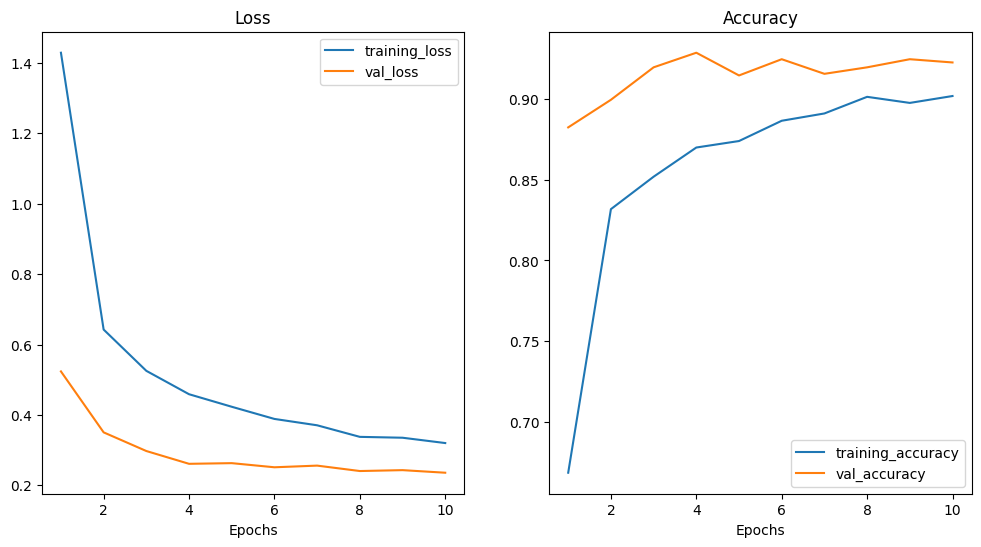

Save model successfully, please move the model and labels to the model_data and labels_data respectively.
Model Testing...
12/12 [==============================] - 4s 174ms/step
Accuracy score on testing dataset: 0.939226508140564


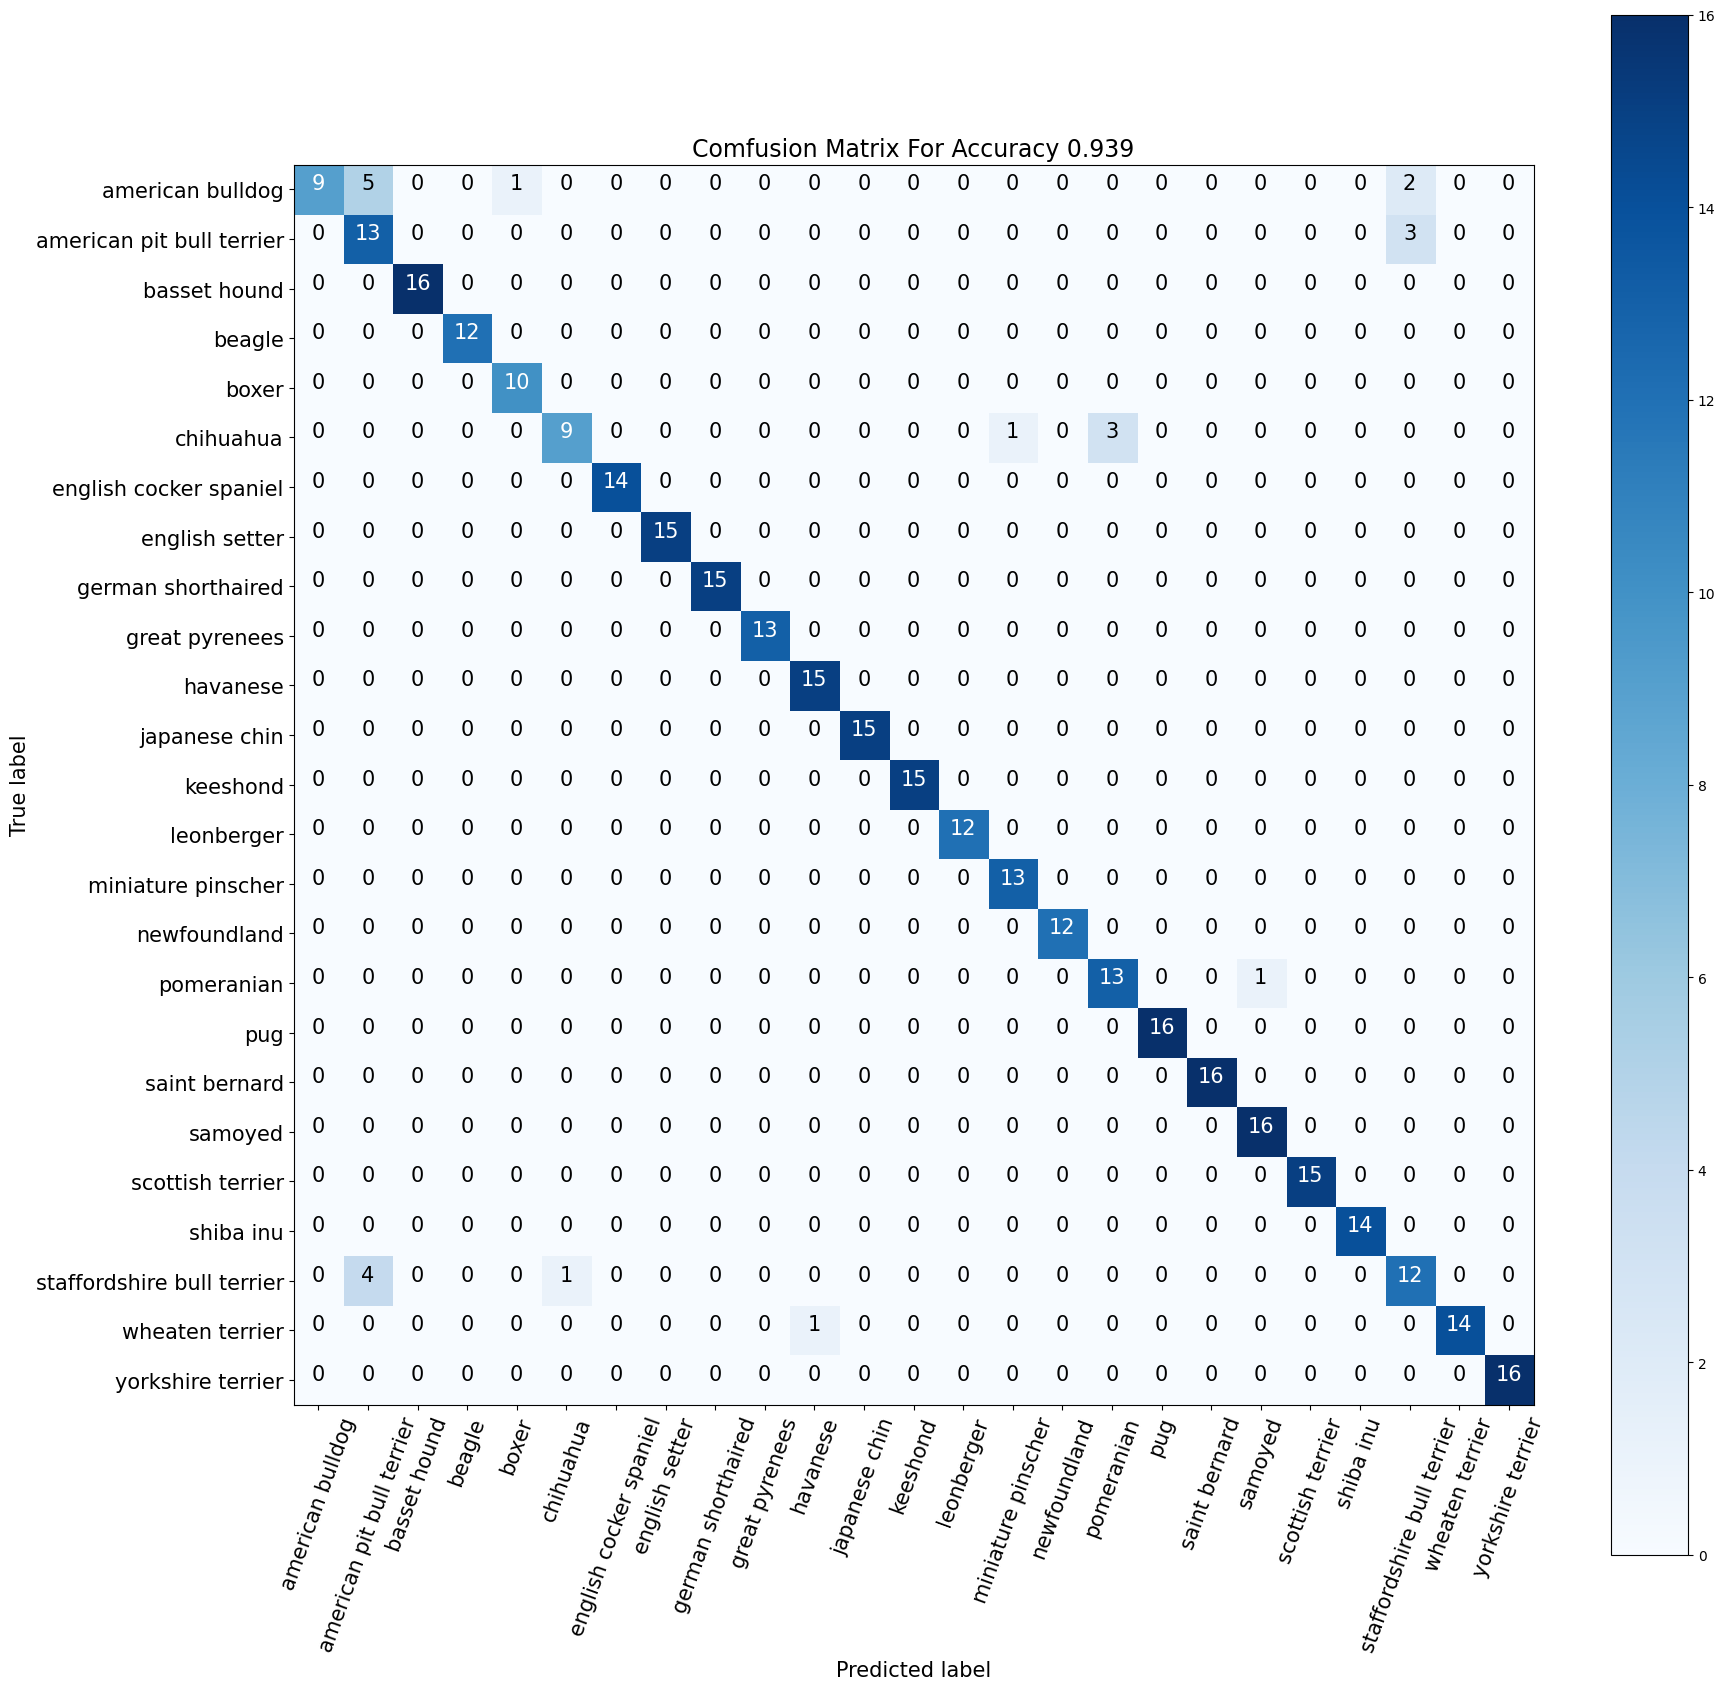

In [10]:
dogs_classifier = train_classifier('dogs', save_model=True, plot_cm=True)

Found 1897 validated image filenames belonging to 12 classes.
Found 474 validated image filenames belonging to 12 classes.
Model: "animal_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 12)                15372     
                                                                 
Total params: 5,934,684
Trainable params: 15,372
Non-train

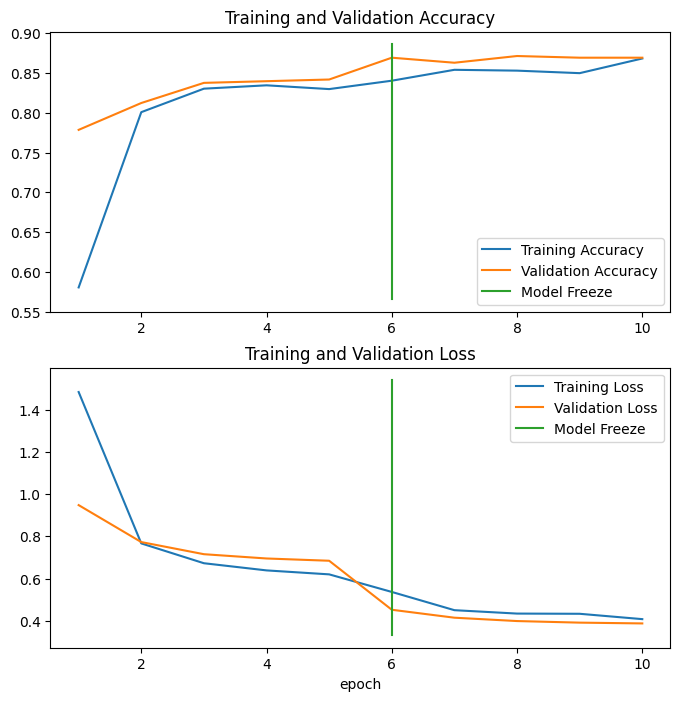

Save model successfully, please move the model and labels to the model_data and labels_data respectively.
Model Testing...
7/7 [==============================] - 3s 235ms/step
Accuracy score on testing dataset: 0.8660287261009216


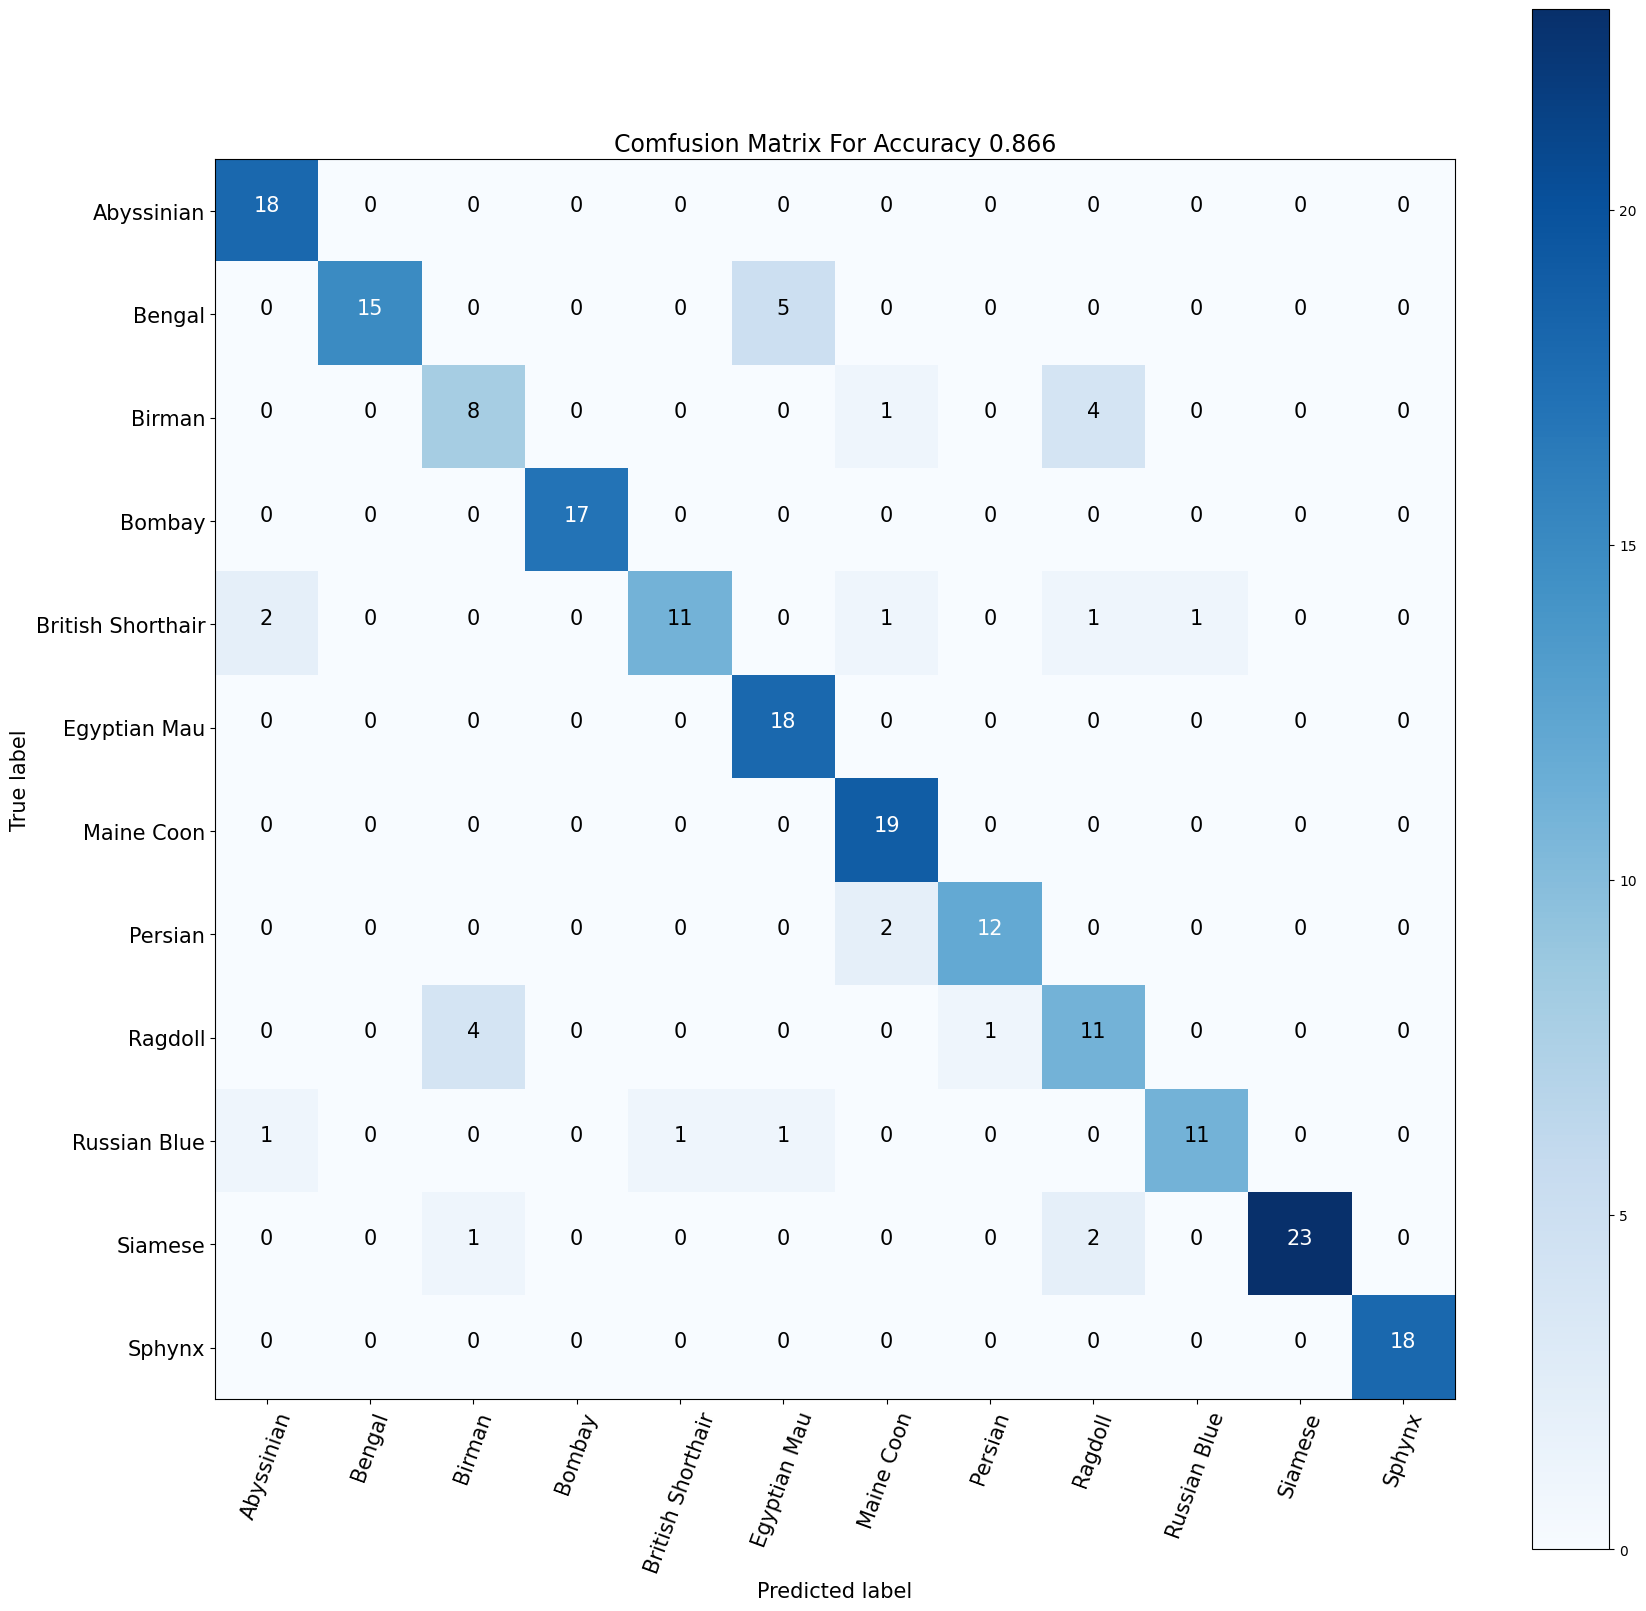

In [11]:
cats_classifier = train_classifier('cats', save_model=True, plot_cm=True)

# Predict one image

Image array shape: (291, 173, 3)
Image array dtype: uint8
1/1 [==============================] - 2s 2s/step


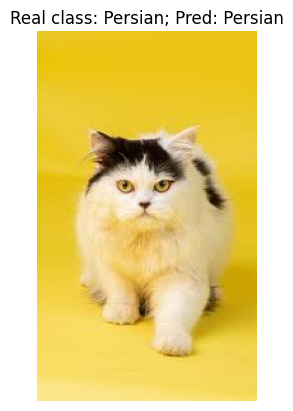

In [14]:
import base64
import random
from io import BytesIO
from PIL import Image
import numpy as np

# Prepare testing images and labels
cats_real_classes = np.load(Path('label_data').joinpath('cats_classes.npy')) # real classes
tets_dataset_path = Path('test_images').joinpath('cats')
real_cats_indices = {'Abyssinian': 0, 'Bengal': 1, 'Birman': 2, 'Bombay': 3,
                     'British Shorthair': 4, 'Egyptian Mau': 5, 'Maine Coon': 6,
                     'Persian': 7, 'Ragdoll': 8, 'Russian Blue': 9,
                     'Siamese': 10, 'Sphynx': 11}
test_image_and_paths = [(img_path, real_cats_indices[cls]) for cls in cats_real_classes \
                                                           for img_path in Path(tets_dataset_path).joinpath(cls).glob('*')]
image_paths, labels = zip(*test_image_and_paths) # separate images and labels

# Select random image
rand_idx = random.randint(0, len(image_paths)-1)
imgPath, imgClass = image_paths[rand_idx], labels[rand_idx]

# Compress the image and return the compressed base64 encoding
def compress_image_to_base64(input_image_path, quality=75):
    # Open the image using OpenCV
    img = cv2.imread(input_image_path)
    
    # Convert image from BGR to RGB (OpenCV uses BGR by default)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert the image to PIL format
    img_pil = Image.fromarray(img_rgb)

    # Use BytesIO to store the compressed image in memory
    buffered = BytesIO()
    
    # Compress the image and save it to the memory's BytesIO object instead of disk
    img_pil.save(buffered, format="JPEG", quality=quality)
    
    # Convert the compressed image data in BytesIO to base64
    img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
    
    return img_base64

# Convert the compressed image to Base64
base64_str = compress_image_to_base64(imgPath, quality=50)

# Display the Base64 result
print_Base64 = lambda base64_str: print(f"Base64 encoding of the image:\n{base64_str}")


# -------------------------------------------
# Convert a base64 encoded image to a NumPy array
def base64_to_array(base64_str):
    # Decode the base64 string back to bytes
    img_data = base64.b64decode(base64_str)
    
    # Use BytesIO to convert the decoded bytes to an image
    img = Image.open(BytesIO(img_data))
    
    # Convert the PIL image to a NumPy array
    img_array = np.array(img)
    
    return img_array

# Test converting Base64 encoded string back to an array
# Convert the base64 string to a NumPy array
img_array = base64_to_array(base64_str)

# Display the image's shape and data type
print("Image array shape:", img_array.shape)
print("Image array dtype:", img_array.dtype)

def Model_Predict(model, image_rgb, img_size=(224, 224)):
    # Image preprocessing
    image_rgb = image_rgb.astype(np.float32)
    resized_image = cv2.resize(image_rgb, img_size) # resize image to (224, 224, 3)
    processed_image = EFNetPreProcessInput(resized_image)  # preprocess image
    image_for_pred = np.expand_dims(processed_image, axis=0) # add a batch dim
    
    # Model prediction
    cats_real_classes = np.load(Path('label_data').joinpath('cats_classes.npy')) # real classes
    model_pred = model.predict(image_for_pred) # predict image
    pred_index = np.argmax(np.squeeze(model_pred)) # get the highest class index
    final_class = cats_real_classes[pred_index] # final image class
    
    return final_class

cats_classifier_loaded = tf.keras.models.load_model(Path('model_data').joinpath('./cats_classifier.h5')) # classifier model
final_class = Model_Predict(cats_classifier_loaded, img_array, img_size=(IMG_SIZE, IMG_SIZE))
plt.imshow(plt.imread(imgPath))
plt.title(f"Real class: {cats_real_classes[imgClass]}; Pred: {final_class}")
plt.axis('off')
plt.show()

# Learning System

In [ ]:
import json
import base64
from PIL import Image
from io import BytesIO
from eval_utils import preprocess_image, create_dataset, calculate_accuracy, evaluate

def compress_image_to_base64(input_image_path:str, 
                             quality:int=100):
    """
    Compress image into base64 data type.
    1. Open the image using OpenCV
    2. Convert image from BGR to RGB (OpenCV uses BGR by default)
    3. Convert the image to PIL format
    4. Use BytesIO to store the compressed image in memory
    5. Compress the image and save it to the memory's BytesIO object instead of disk
    6. Convert the compressed image data in BytesIO to base64
    """
    img = cv2.imread(input_image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    buffered = BytesIO()
    img_pil.save(buffered, format="JPEG", quality=quality)
    img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
    
    return img_base64
    
species = 'cats'
test_image_path = 'Bengal.jpg'
image = compress_image_to_base64(test_image_path)
result = 'no'
breed = 'Bengal'
feedback = {'species': species, 'image': image, 'result': result, 'breed': breed}

class LearningSystem():
    def __init__(self, user_name:str, feedback:json, DATA_PATH:str, ANNOTATION_PATH:str, fine_tune_ratio:float=0.05):
        self.user_name = user_name
        self.feedback = json.loads(feedback)
        self.fine_tune_ratio = fine_tune_ratio
        # self._save = self.update_historical_data(self.user_name, self.image, self.feedback)

        # Training parameters
        self.IMG_SIZE = 224
        self.BATCH_SIZE = 32
        self.DATA_PATH = DATA_PATH
        self.ANNOTATION_PATH = ANNOTATION_PATH

        self.species = self.feedback['species']
        self.image = self.feedback['image']
        self.result = self.feedback['result']
        self.breed = self.feedback['breed']
        
        self.real_classes = np.load('cats_classes.npy') if self.species == 'cats' else np.load('dogs_classes.npy')
        self.new_model_name = self.species + '_classifier_new.h5'

    def append_to_file(self, new_line:str):
        """
        Append new information about image classification.
    
        Args:
            new_line: Content of image information
        """
        # Use append mode to add new content
        with open(self.ANNOTATION_PATH, 'a') as file:
            file.write(f'\n{new_line}')
        print(f'Add {new_line} info at {self.ANNOTATION_PATH}')

    def decode_and_save(self, fPath:str):
        """
        Decode image from base64 byte into Numpy array, and save image.
    
        Args:
            fname: Path for image saving
        """
        img_data = base64.b64decode(self.image)
        img = Image.open(BytesIO(img_data))
        img.save(fPath)
        print(f'Save image at {fPath}')

    def load_classifier(self):
        """Load pre-train model for fine-tuning"""
        if Path(self.new_model_name).is_file():
            classifier = tf.keras.models.load_model(self.new_model_name)
        else:
            classifier = tf.keras.models.load_model('cats_classifier.h5')

        return classifier

    def unfreeze(self):
        fine_tune_base_model = self.classifier.layers[1]
        layer_number = -int(len(fine_tune_base_model.layers) * self.fine_tune_ratio)
        
        # Unfreeze all of the layers in the base model
        fine_tune_base_model.trainable = True
        
        # Refreeze every layer except for the last 5
        for layer in fine_tune_base_model.layers[:layer_number]:
            layer.trainable = False
        
    def fine_tune_classifier(self):
        
        # Set random seed and clear session
        seed = 42
        np.random.seed(seed)
        tf.random.set_seed(seed)
        tf.keras.backend.clear_session()

        fname = self.breed + '_' + time_now().strftime(format='%Y%m%d-%H%M%S')
        IMAGE = save_path = fname + '.jpg'
        CLASS_ID = '999'
        SPECIES = 1 if self.species == 'cats' else 2
        BREED_ID = np.where(self.real_classes == self.breed)[0][0]+1
        CLASSNAME = self.breed

        # Append to txt file  
        self.append_to_file(f'{fname} {CLASS_ID} {SPECIES} {BREED_ID}')

        # Save image into dataset
        self.decode_and_save(fPath=self.DATA_PATH.joinpath(save_path))

        # Add image into folder and annotation txt
        self.data_transformer = DataTransformer(self.ANNOTATION_PATH)        

        # Data augmentation
        self.data_df = self.data_transformer.preprocess()
        self.data_with_feedback_df = self.data_df[self.data_df['SPECIES'] == SPECIES]
        self.data_aug = DataAugmentation(dataframe=self.data_with_feedback_df, 
                                         img_data_path=self.DATA_PATH, 
                                         img_size=self.IMG_SIZE, 
                                         batch_size=self.BATCH_SIZE, 
                                         preprocess_function=EFNetPreProcessInput)
        
        self.train_data_gen, self.valid_data_gen = self.data_aug.create_flow()

        # Model loading
        self.classifier = self.load_classifier()
        self.unfreeze()

        # Compile model
        self.classifier.compile(loss='categorical_crossentropy', 
                                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                                metrics=['accuracy'])
        # Train model
        self.classifier.fit(self.train_data_gen, 
                            epochs=3,
                            validation_data=self.valid_data_gen)
    
        # Model evaluation
        species_path = './test_images/%s' % (species)
        acc_score = evaluate(self.train_data_gen.class_indices, self.real_classes, species_path, self.classifier)
        print(f"Accuracy score on testing dataset: {acc_score}")

        # Save model
        self.classifier.save(self.new_model_name)
        print(f'New classifier has been save at {self.new_model_name}')
        print('OK')
        
learning_sys = LearningSystem(user_name='Leo', feedback=json.dumps(feedback), DATA_PATH=DATA_PATH, ANNOTATION_PATH=ANNOTATION_PATH)
learning_sys.fine_tune_classifier()

In [12]:
# cats and dogs labels
LABEL_PATH = 'C:\\Users\\User\\Desktop\\cat_dog_project\\CatDogClassification\\label_data'
cat_labels = np.load(Path(LABEL_PATH).joinpath('cats_classes.npy'))
dog_labels = np.load(Path(LABEL_PATH).joinpath('dogs_classes.npy'))

In [11]:
cat_labels

array(['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British Shorthair',
       'Egyptian Mau', 'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue',
       'Siamese', 'Sphynx'], dtype='<U17')

In [13]:
dog_labels

array(['american bulldog', 'american pit bull terrier', 'basset hound',
       'beagle', 'boxer', 'chihuahua', 'english cocker spaniel',
       'english setter', 'german shorthaired', 'great pyrenees',
       'havanese', 'japanese chin', 'keeshond', 'leonberger',
       'miniature pinscher', 'newfoundland', 'pomeranian', 'pug',
       'saint bernard', 'samoyed', 'scottish terrier', 'shiba inu',
       'staffordshire bull terrier', 'wheaten terrier',
       'yorkshire terrier'], dtype='<U26')

# EWC (elastic-weight-consolidation)

Here’s the revised summary about this paper [Overcoming catastrophic forgetting in neural
networks](https://arxiv.org/pdf/1612.00796) :

### Introduction
Achieving continual learning, which allows artificial intelligence to learn new tasks without forgetting previous ones, is crucial. However, neural networks often face the issue of "catastrophic forgetting" when learning tasks sequentially, where the knowledge of previously learned tasks is overwritten when learning new ones.

The goal of this paper is to solve the problem of catastrophic forgetting and enable neural networks to switch between tasks effectively while retaining knowledge from previous tasks.

### Elastic Weight Consolidation (EWC)
Humans and other animals have the ability to learn continuously without experiencing catastrophic forgetting, unlike artificial neural networks. Recent research shows that the mammalian brain prevents forgetting by protecting previously acquired knowledge within neocortical circuits. When a new skill is learned, a portion of excitatory synapses strengthens, leading to an increase in dendritic spine volume, which remains stable even when new tasks are learned, allowing for long-term retention of the skill. If these spines are selectively removed, the corresponding skill is forgotten, providing evidence that the stability of these synapses is essential for retaining learned tasks. This process, known as task-specific synaptic consolidation, is a key mechanism for continual learning, as modeled by neurobiological studies.

EWC is an algorithm that mimics synaptic consolidation by selectively constraining certain important parameters from being altered during the learning of new tasks. The importance of these parameters is measured using the Fisher Information Matrix, which adjusts the learning rate based on the parameters' significance for previous tasks.

**How EWC Works**:
- In a neural network, a quadratic penalty term is added to the loss function, which ensures that critical parameters remain close to their previous values. This prevents these parameters from being significantly changed during the learning of new tasks.
- As a result, EWC allows the network to learn new tasks (e.g., task B) while minimizing the loss of knowledge from previous tasks (e.g., task A).

### EWC Formula:
The loss function $L(\theta)$ in EWC consists of two components:
1. The loss $L_B(\theta)$ for the new task B.
2. A penalty term related to the old task A.

The loss function is expressed as:
$L(\theta) = L_B(\theta) + \sum_{i} \frac{\lambda}{2} F_i (\theta_i - \theta_{A,i}^*)^2$
- $L_B(\theta)$: Loss for the current new task B.
- $\lambda$: A parameter that balances the importance of old and new tasks.
- $F_i$: The $i$-th diagonal element of the Fisher Information Matrix, representing the importance of parameter $\theta_i$ for the old task A.
- $\theta_{A,i}^*$: The optimal value of parameter $\theta_i$ for task A.

### Key Points:
- **Penalty Term**: This quadratic penalty term ensures that the important parameters for previous tasks are kept close to their old values while learning new tasks.
- **Fisher Information Matrix**: Used to determine the importance of each weight for previous tasks, adjusting the strength of the penalty applied to each parameter.

These formulas and concepts help neural networks achieve continual learning by preventing the forgetting of old tasks while learning new ones.

### Application in Supervised Learning
- **MNIST Experiment**: Experiments on the permuted MNIST dataset demonstrated EWC’s effectiveness in multi-task learning. Compared to traditional SGD, EWC effectively mitigates catastrophic forgetting, allowing the network to retain performance on old tasks while learning new ones.

### Application in Reinforcement Learning
- **Atari Games Experiment**: In the domain of Atari 2600 games, EWC helped Deep Q-Networks (DQNs) learn multiple game tasks sequentially without forgetting previously acquired skills.

[elastic-weight-consolidation-tf2](https://github.com/stijani/elastic-weight-consolidation-tf2)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np
from tqdm import tqdm


def evaluate(model, test_x, test_y):
    acc = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
    for imgs, labels in zip(test_x, test_y):
        preds = model.predict_on_batch(np.array([imgs]))
        acc.update_state(labels, preds)
    return round(100*acc.result().numpy(), 2)


class Train:
    def __init__(self, optimizer, loss_fn, prior_weights=None, lambda_=0.1):
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.prior_weights = prior_weights
        self.lambda_ = lambda_
        
    def train(self, model, epochs, train_task, fisher_matrix=None, test_tasks=None):
        # empty list to collect per epoch test acc of each task
        if test_tasks:
            test_acc = [[] for _ in test_tasks]
        else: 
            test_acc = None
        for epoch in tqdm(range(epochs)):
            for batch in train_task:
                X, y = batch
                with tf.GradientTape() as tape:
                    pred = model(X)
                    loss = self.loss_fn(y, pred)
                    # if to execute training with EWC
                    if fisher_matrix is not None:
                        loss += self.compute_penalty_loss(model, fisher_matrix)
                grads = tape.gradient(loss, model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # evaluate with the test set of task after each epoch
            if test_acc:
                for i in range(len(test_tasks)):
                    test_acc[i].append(evaluate(model, test_tasks[i][0], test_tasks[i][1]))
        return test_acc

    def compute_penalty_loss(self, model, fisher_matrix):
        penalty = 0.
        for u, v, w in zip(fisher_matrix, model.weights, self.prior_weights):
            penalty += tf.math.reduce_sum(u * tf.math.square(v - w))
        return 0.5 * self.lambda_ * penalty
    

class EWC:
    def __init__(self, prior_model, data_samples, num_sample=30):
        self.prior_model = prior_model
        self.prior_weights = prior_model.weights
        self.num_sample = num_sample
        self.data_samples = data_samples
        self.fisher_matrix = self.compute_fisher()
        
    def compute_fisher(self):
        weights = self.prior_weights
        fisher_accum = np.array([np.zeros(layer.numpy().shape) for layer in weights], 
                                dtype=object)
        for j in tqdm(range(self.num_sample)):
            idx = np.random.randint(self.data_samples.shape[0])
            with tf.GradientTape() as tape:
                logits = tf.nn.log_softmax(self.prior_model(np.array([self.data_samples[idx]])))
            grads = tape.gradient(logits, weights)
            for m in range(len(weights)):
                fisher_accum[m] += np.square(grads[m])
        fisher_accum /= self.num_sample
        return fisher_accum
    
    def get_fisher(self):
        return self.fisher_matrix
    

class MLP3:
    def __init__(self, input_shape=(28, 28), hidden_layers_neuron_list=[200, 200], num_classes=10):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.hidden_layers_neuron_list = hidden_layers_neuron_list
        self.model = self.create_mlp()
        
    def create_mlp(self):
        model = Sequential([
                Flatten(input_shape=self.input_shape),
                Dense(self.hidden_layers_neuron_list[0], input_shape=self.input_shape, activation='relu'),
                Dense(self.hidden_layers_neuron_list[1], activation='relu'),
                Dense(self.num_classes)
        ])
        return model
    
    def get_uncompiled_model(self):
        return self.model
    
    def get_compiled_model(self, optimizer, loss_fn, metrics ):
        compiled_model = self.model
        compiled_model.compile(optimizer, loss_fn, metrics)
        return compiled_model


In [ ]:
class AnimalClassifier:
    def __init__(self, base_model, input_shape, output_shape, epochs=5, Init_lr=1e-3,
                 fine_tune_ratio=None, fine_tune_epochs=3, lr_decay_type:str=''):
        """
        Args:
          base_model: Transfer learning model passed into building structure.
          input_shape: Input shape for the transfer model.
          output_shape: Output shape for the transfer model.
          epochs: Epochs for model training.
          fine_tune_ratio: Ratio for trainable layers of base model.
          fine_tune_epochs: Epochs for model fine-tuning.
          lr_decay_type: Type of learning rate decay
        """
        self.base_model       = base_model
        self.input_shape      = input_shape
        self.output_shape     = output_shape
        self.epochs           = epochs
        self.fine_tune_ratio  = fine_tune_ratio
        self.fine_tune_epochs = fine_tune_epochs
        self.Epoch            = self.epochs + self.fine_tune_epochs

        # ----------------------------
        # Model optimization
        # 1. learning rate scheduler
        # 2. learning rate decay
        # ----------------------------
        self.Init_lr           = Init_lr
        self.Adam              = tf.keras.optimizers.Adam
        self.compile_model     = lambda model, lr=self.Init_lr: model.compile(loss='categorical_crossentropy', 
                                                                              optimizer=self.Adam(learning_rate=lr), 
                                                                              metrics=['accuracy'])
        if lr_decay_type:
            self.lr_decay_type = lr_decay_type
            self.Min_lr        = self.Init_lr * 0.001
            self.lr_func       = self.get_lr_scheduler(lr_decay_type=self.lr_decay_type, 
                                                       lr=self.Init_lr, 
                                                       min_lr=self.Min_lr, 
                                                       total_iters=self.Epoch)
            self.lr_scheduler  = tf.keras.callbacks.LearningRateScheduler(self.lr_func, verbose=1)
            self.callbacks     = [self.lr_scheduler]
        else:
            self.reduce_lr     = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1, 
                                                                      verbose=2, min_lr=self.Init_lr * 0.0001, mode='min')
            self.callbacks     = [self.reduce_lr]
        
    def build_model(self):
        """Build a transfer learning model."""
        self.base_model.trainable = False
    
        inputs = tf.keras.layers.Input(shape=self.input_shape, name="input_layer")
        x = self.base_model(inputs, training=False)
        x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
        outputs = tf.keras.layers.Dense(self.output_shape, activation="softmax", name="output_layer")(x)
        model = tf.keras.Model(inputs, outputs, name="animal_classifier")
    
        print(model.summary())
    
        return model

    def get_lr_scheduler(self, lr_decay_type:str, lr:float, min_lr:float, total_iters:int,
                         warmup_iters_ratio:float=0.1, warmup_lr_ratio:float=0.1, no_aug_iter_ratio:float=0.3, step_num:int=10):
        """
        Functions for learning rate decay, cosine or step decay.
    
        Args:
            lr_decay_type: Type of learning rate decay, cos or step
            lr: Learning rate
            min_lr: Minimum learning rate
            total_iters: Total iterations of training
            warmup_iters_ratio: Ratio for warm up iteration
            warmup_lr_ratio: Ratio for warm up learning rate
            no_aug_iter_ratio: Ratio for no augmentation iterations, this phase will maintain at minimum learning rate.
            step_num: Number of steps for step decay
        Returns:
            Function for learning rate decay.
        """
        def yolox_warm_cos_lr(lr, min_lr, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter, iters):
            if iters <= warmup_total_iters: # warm up iters
                lr = (lr - warmup_lr_start) * pow(iters / float(warmup_total_iters), 2) + warmup_lr_start
            elif iters >= total_iters - no_aug_iter: # no augmentation iters, it will maintain at minimum iter
                lr = min_lr
            else: # learning rate decay
                lr = min_lr + 0.5 * \
                    (lr - min_lr) * \
                    (1.0 + math.cos(math.pi * (iters - warmup_total_iters) / (total_iters - warmup_total_iters - no_aug_iter)))
            return lr

        def step_lr(lr, decay_rate, step_size, iters):
            if step_size < 1:
                raise ValueError("step_size must above 1.")
            n       = iters // step_size # Number of steps
            out_lr  = lr * decay_rate ** n # learning rate decay
            return out_lr
        
        if lr_decay_type == "cos":
            warmup_total_iters  = min(max(warmup_iters_ratio * total_iters, 1), 3) # range [1, 3]
            warmup_lr_start     = max(warmup_lr_ratio * lr, 1e-3) # at least 1e-3
            no_aug_iter         = min(max(no_aug_iter_ratio * total_iters, 1), 3) # range [1, 5]
            func = partial(yolox_warm_cos_lr ,lr, min_lr, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter)
        else:
            decay_rate          = (min_lr / lr) ** (1 / (step_num - 1)) # decay rate
            step_size           = total_iters / step_num
            func                = partial(step_lr, lr, decay_rate, step_size)

        return func

    def train(self, train_data, valid_data):
        self.model = self.build_model()
        self.compile_model(self.model, lr=self.Init_lr)
        self.original_history = self.model.fit(train_data, 
                                               epochs=self.epochs,
                                               validation_data=valid_data,
                                               callbacks=[self.callbacks],
                                               initial_epoch=0)
        if self.fine_tune_ratio:
            self.fine_tune_model_layers()
            self.compile_model(self.model, lr=self.Init_lr * 0.1)
            self.new_history = self.model.fit(train_data, 
                                              epochs=self.epochs+self.fine_tune_epochs,
                                              validation_data=valid_data,
                                              callbacks=[self.callbacks],
                                              initial_epoch=self.epochs)
            self.compare_historys()
        else: 
            self.plot_loss_curves()

    def fine_tune_model_layers(self):
        """Set specific layers being trainable for further model training."""
        fine_tune_base_model = self.model.layers[1]
        layer_number = -int(len(fine_tune_base_model.layers) * self.fine_tune_ratio)
    
        # Unfreeze all of the layers in the base model
        fine_tune_base_model.trainable = True
    
        # Refreeze every layer except for the last 5
        for layer in fine_tune_base_model.layers[:layer_number]:
            layer.trainable = False
    
        print(f"Change last {-layer_number} layers of {fine_tune_base_model.name} successfully, please recompile model again.")
    
    def plot_loss_curves(self):
        """Returns separate loss curves for training and validation metrics."""
        # Get original history
        history = self.original_history.history
        
        # losses and accuracy
        loss = history["loss"]
        val_loss = history["val_loss"]
        accuracy = history["accuracy"]
        val_accuracy = history["val_accuracy"]
    
        # epochs
        epochs = range(1, len(history["loss"])+1)
    
        # plot loss and accuracy
        plt.figure(figsize=(12, 6))
        plt.subplot(1,2,1)
        plt.plot(epochs, loss, label="training_loss")
        plt.plot(epochs, val_loss, label="val_loss")
        plt.title("Loss")
        plt.xlabel("Epochs")
        plt.legend()
    
        plt.subplot(1,2,2)
        plt.plot(epochs, accuracy, label="training_accuracy")
        plt.plot(epochs, val_accuracy, label="val_accuracy")
        plt.title("Accuracy")
        plt.xlabel("Epochs")
        plt.legend();

    def compare_historys(self):
        """Compares two TensorFlow model History objects."""
        # Get history and epochs
        original_history = self.original_history.history
        new_history = self.new_history.history
        initial_epochs = self.epochs+1
        epochs = range(1, initial_epochs+self.fine_tune_epochs)
        
        # Get original history measurements
        acc = original_history["accuracy"]
        loss = original_history["loss"]
    
        val_acc = original_history["val_accuracy"]
        val_loss = original_history["val_loss"]
    
        # Combine original history with new history
        total_acc = acc + new_history["accuracy"]
        total_loss = loss + new_history["loss"]
    
        total_val_acc = val_acc + new_history["val_accuracy"]
        total_val_loss = val_loss + new_history["val_loss"]
    
        # Make plots
        plt.figure(figsize=(8, 8))
        plt.subplot(2,1,1)
        plt.plot(epochs, total_acc, label='Training Accuracy')
        plt.plot(epochs, total_val_acc, label='Validation Accuracy')
        plt.plot([initial_epochs, initial_epochs], plt.ylim(), label='Model Freeze') # shift plot around epochs
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
    
        plt.subplot(2,1,2)
        plt.plot(epochs, total_loss, label='Training Loss')
        plt.plot(epochs, total_val_loss, label='Validation Loss')
        plt.plot([initial_epochs, initial_epochs], plt.ylim(), label='Model Freeze') # shift plot around epochs
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        plt.show()

In [ ]:
# Set random seed and clear session
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.backend.clear_session()
ANNOTATION_PATH = './Cats_and_Dogs_Breeds_Classification_Oxford_Dataset/annotations/annotations/list.txt'
IMG_SIZE = 224
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 32
DATA_PATH = './Cats_and_Dogs_Breeds_Classification_Oxford_Dataset/images/images'


def get_classes(class_indices:dict, save_path='') -> list:
    """
    Get animal classes from class indices of dictionary.

    Args:
        class_indices: Class indices in dictionary data type.
    Returns: 
        Class names in list data type.
    """
    pairs = [(cls_name, index) for cls_name, index in class_indices.items()] # convert to list with tuple
    pairs_sorted = sorted(pairs, key=lambda pairs: pairs[1]) # sorting values
    classes = np.array([pair_cls[0] for pair_cls in pairs_sorted]) # convert to numpy array
    if save_path: np.save(save_path, classes) # save labels

    return classes


def preprocess_image(image_path:str, size:tuple=(IMG_SIZE, IMG_SIZE)) -> np.array:
    """
    Preprocess images by following steps:
    1. read image
    2. convert image into RGB channel (OpenCV default BGR)
    3. resize image to size+(3,)
    4. preprocess image by efficientNet preprocess input

    Args:
        image_path: Image path for preprocessing
        size: image size for resizing
    Returns:
        Processed images in numpy array data type
    """
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image_rgb, size)
    final_image = EFNetPreProcessInput(resized_image)
    
    return final_image

def create_dataset(images:np.array, batch_size:int=32) -> tf.data.Dataset:
    """Create dataset from images."""
    # generate image dataset
    image_ds = tf.data.Dataset.from_tensor_slices(tf.constant(images))
    
    # convert image dataset to 32 batch size
    image_ds = image_ds.batch(batch_size)
    image_ds = image_ds.prefetch(buffer_size=tf.data.AUTOTUNE)  # prefetch data for higher efficiency
    
    return image_ds

def calculate_accuracy(y_true:tf.Tensor, y_pred:tf.Tensor) -> np.float32:
    """
    Create accuracy score via true labels and model predictions.

    Args:
        y_true: True labels from dataset
        y_pred: Model predictions
    Returns:
        Accuracy score
    """
    results = tf.equal(tf.argmax(y_pred, axis=1), tf.argmax(y_true, axis=1))
    results_to_float = tf.cast(results, tf.float32)
    accuracy_score = tf.reduce_mean(results_to_float).numpy()

    return accuracy_score

def evaluate(class_indices:dict, real_classes:list, species_path:str, model:tf.keras.Model) -> float:
    """
    Evaluate model performance from test images collected before.

    Ags:
        class_indices: Dictionary of class names and class indices
        real_classes: List of real classes
        species_path: Test images path
        model: Model for evaluation
    Returns:
        Accuracy score in float data type
    """
    # Prepare testing images and labels
    test_image_and_paths = [(img_path, class_indices[cls]) for cls in real_classes \
                                                           for img_path in Path(species_path).joinpath(cls).glob('*')]
    image_paths, labels = zip(*test_image_and_paths) # separate images and labels
    test_images = [preprocess_image(str(img_path), size=(IMG_SIZE, IMG_SIZE)) for img_path in image_paths] # prepare test images
    test_labels = tf.one_hot(labels, depth=len(np.unique(np.array(labels)))) # prepare test labels with one hot encoding
    test_dataset = create_dataset(test_images, batch_size=BATCH_SIZE) # create testing dataset by tensorflow
    y_preds = model.predict(test_dataset)
    Acc_Score = calculate_accuracy(test_labels, y_preds)

    return Acc_Score

def train_classifier(species:str='', save_model=False) -> AnimalClassifier:
    # Data preprocessing
    data_transformer = DataTransformer(ANNOTATION_PATH)
    data_df = data_transformer.preprocess()

    # Data augmentation
    if species.lower() == 'cats':
        df_species = data_df[data_df['SPECIES']==1] # cat : 1 --> epochs: 5, fine_tune_ratio=0.15, fine_tune_epochs=5
        params = {'epochs': 5, 'fine_tune_ratio': 0.15, 'fine_tune_epochs': 5, 'lr_decay_type': 'step'}
    elif species.lower() == 'dogs':
        df_species = data_df[data_df['SPECIES']==2] # dog : 2 --> epochs: 10, fine_tune_ratio=None, fine_tune_epochs=0
        params = {'epochs': 10, 'fine_tune_ratio': None, 'fine_tune_epochs': 0, 'lr_decay_type': None}
    else: raise ValueError('cats or dogs only !')
    
    data_aug = DataAugmentation(dataframe=df_species,
                                img_data_path=DATA_PATH, 
                                img_size=IMG_SIZE, 
                                batch_size=BATCH_SIZE, 
                                preprocess_function=EFNetPreProcessInput)
    train_data_gen, valid_data_gen = data_aug.create_flow()

    # prepare label classes
    class_indices = train_data_gen.class_indices
    real_classes = get_classes(class_indices, save_path='%s_classes.npy'%(species))
    
    # Model training
    base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
    breed_classifier = AnimalClassifier(base_model,  
                                        input_shape=INPUT_SHAPE, 
                                        output_shape=len(real_classes), 
                                        epochs=params['epochs'], 
                                        Init_lr=1e-3,
                                        fine_tune_ratio=params['fine_tune_ratio'], 
                                        fine_tune_epochs=params['fine_tune_epochs'], 
                                        lr_decay_type=params['lr_decay_type'])
    breed_classifier.train(train_data_gen, valid_data_gen)

    # Model saving
    if save_model: breed_classifier.model.save('%s_classifier.h5'%(species))

    # Model evaluation
    species_path = './test_images/%s' % (species)
    acc_score = evaluate(class_indices, real_classes, species_path, breed_classifier.model)
    print(f"Accuracy score on testing dataset: {acc_score}")

    return breed_classifier

# dogs_classifier = train_classifier('dogs', save_model=True)
cats_classifier = train_classifier('cats', save_model=True)

# End